## COMP411/511  HW1
### Deadline: 20 November 2024, 23.59

Before starting, create a virtual environment and install the required packages

### Step 1: Create a conda environment and activate

```
$ conda create -n comp411_511
$ conda activate comp411_511
```
You can learn more on Conda environments here: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html

### Step 2: download the required packages and install

For Mac:
```
$ conda install pytorch::pytorch torchvision torchaudio -c pytorch
$ pip install numpy
$ pip install matplotlib
```

For Linux:
```
$ conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
$ pip install numpy
$ pip install matplotlib
```
If you have any issues with installation, try to follow steps in the official PyTorch documentation: https://pytorch.org


As an alternative, you can use Google Colab to run the code. Just upload the notebook and run it


In [1]:
# HW1
#
# You have TODOs in this code. They are all marked with "TODO" in comments.
# Your task is to fill them in with the correct code. Do not change any other code.
# You also have some questions to answer. They are marked with "QA" as markdown cells.
#
# Parts:
# 1. PyTorch Data Basiscs (15 points)
# 2. Layer Initialization (10 points)
# 3. Training for Multiclass Classification with Cross-Entropy Loss (42 points)
# 4. Multiclass Classification using Binary Cross Entropy with Sigmoid (19 points)
# 5. Multilayer Networks (19 points)
# 6. Open-ended Questions (5 points)
#
# Total: 110 points
# Your grade will be normalized to 100 points

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np

In [3]:
NUM_TRAIN = 49000


# The CIFAR-10 dataset is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories.
# We download the dataset and create a DataLoader object for the training set and the validation set.
# The transform function converts the image to a tensor and normalizes it
# The normalization is done to make the pixel values lie in the range [-1, 1]
# The first argument of Normalize is the mean and the second argument is the standard deviation
# The mean and standard deviation are used to normalize the pixel values
# The mean and standard deviation are calculated for each channel (RGB) separately

transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = dset.CIFAR10('./comp411_511/datasets', train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./comp411_511/datasets', train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Each item in the train set is a tuple of the form:
# (image, label)
# where image is the image tensor and label is the index of the class label.
# The image tensor is of shape (3, 32, 32) and the label is an integer in the range [0, 9]
# Now on, you can use loader_train to get batches of images for training your model in each iteration
# You can reach each data sample in the batch by indexing the data sample tuple

Files already downloaded and verified
Files already downloaded and verified


# PyTorch Data Basics (15 pts)

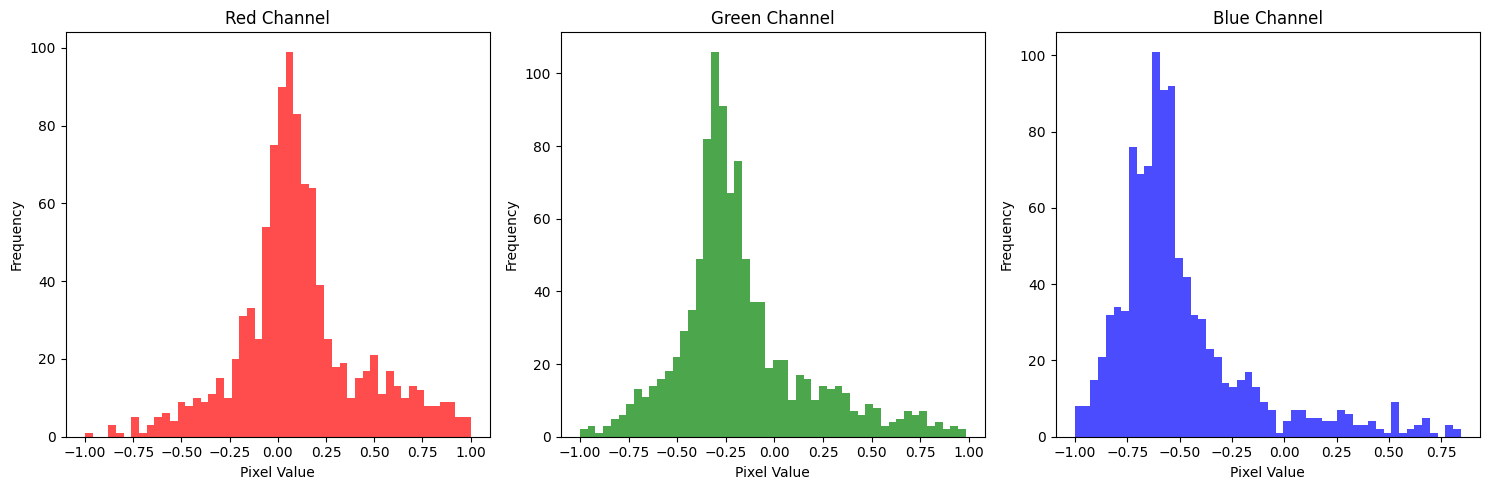

In [4]:
# TODO: Plot the histogram of values in images 0, for each channel, side by side, using axes

# === Your Code Here (5 pts) ===
image, label = cifar10_train[0]
image

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

channels = ['Red', 'Green', 'Blue']
for i in range(3):
    axes[i].hist(image[i].numpy().flatten(), bins=50, color=channels[i].lower(), alpha=0.7)
    axes[i].set_title(f'{channels[i]} Channel')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
# === === ===


## QA (6 pts)
Q: What can you say about the distribution of pixel values in the images? (2 pts)

A: The pixel values peak at a particular value, and this peak is not necessarily at 0, they are skewed. The distribution is different for different channels.

---

Q: Why do we need to normalize the images? (2 pts)

A: Normalization improves optimization, and the noise introduced has a regularizing effect. It scales the pixel values to a given range and thus eliminates the problems caused by magnitude differences accorss channels/features.

---

Q: What is the range of pixel values in the original images? (2 pts)

A: The pixel values range from 0 to 255.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


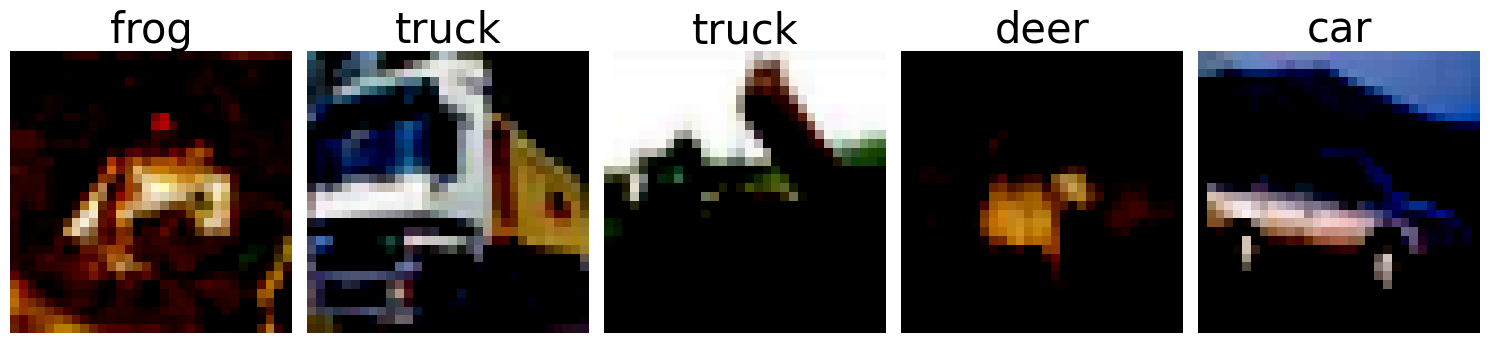

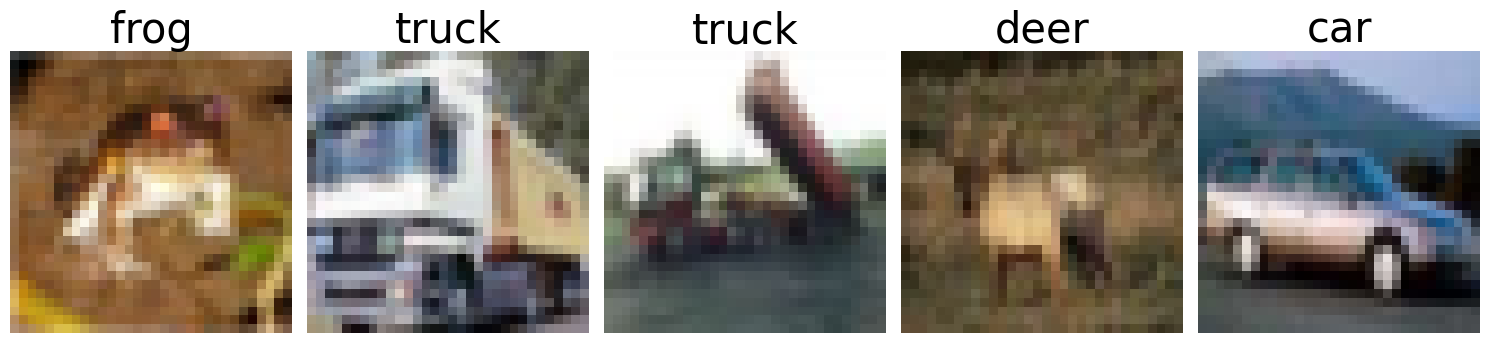

In [5]:
# TODO: Plot the first 5 images from the training dataset, using matplotlib. Set the title as the class name of the image
# === Your Code Here (2 pts) ===
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image, label = cifar10_train[i] 
    img = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) for display
    axes[i].imshow(img)
    axes[i].set_title(classes[label], fontsize=30)
    axes[i].axis('off')  # Remove axes for better visualization

plt.tight_layout()
plt.show()
# === === ===

# TODO: Denormalize the images and plot the first 5 images from the training dataset, using matplotlib
# Denormalization is the process of converting the pixel values from their normalized form to the original pixel values
# === Your Code Here (2 pts) ===
def denormalize(image):
    # Reverse normalization: x = (x_norm * std) + mean
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    return image * std[:, None, None] + mean[:, None, None]

def plot_denorm(i):
    image, label = cifar10_train[i]
    denorm_img = denormalize(image.numpy())
    axes[i].imshow(denorm_img.transpose(1, 2, 0).clip(0, 1))  # Convert to (H, W, C)
    axes[i].set_title(classes[label], fontsize=30)
    axes[i].axis('off')

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    plot_denorm(i)

plt.tight_layout()
plt.show()

# === === ===

## Layer Initialization (10 pts)

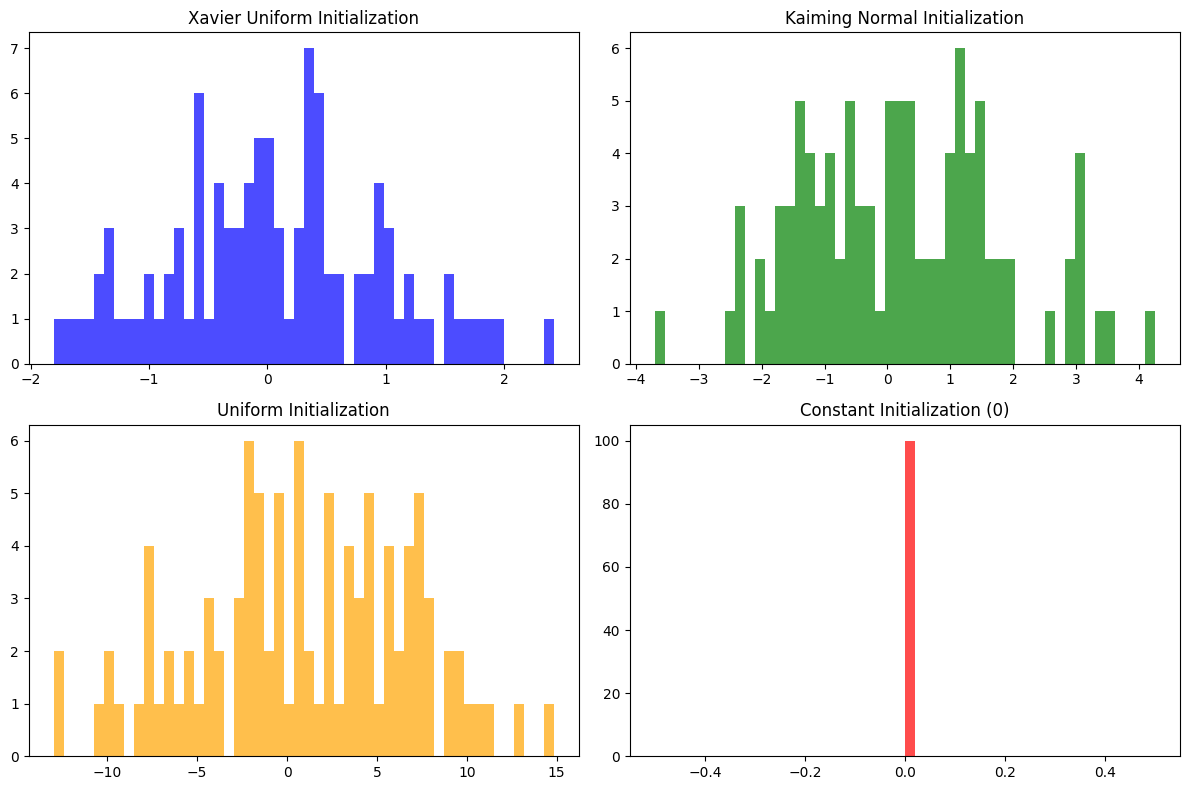

In [6]:
# TODO: Create a single layer, with nn.Linear, that takes 100 inputs and gives 100 outputs
# Initialize the weights with i) xavier uniform ii) kaiming normal iii) uniform iv) constant 0
# Please see the initialization functions in the PyTorch documentation: https://pytorch.org/docs/stable/nn.init.html
# Plot the histogram of the outputs for each initialization method, giving the random input x as input

# random input
x = torch.randn(1, 100)

# === Your Code Here (6 pts) ===

# Initialize the nn.Linear layer
layer_xavier = nn.Linear(100, 100)
layer_kaiming = nn.Linear(100, 100)
layer_uniform = nn.Linear(100, 100)
layer_constant = nn.Linear(100, 100)

# initialization methods
nn.init.xavier_uniform_(layer_xavier.weight)
nn.init.kaiming_normal_(layer_kaiming.weight, nonlinearity='relu')
nn.init.uniform_(layer_uniform.weight, a=-1, b=1)
nn.init.constant_(layer_constant.weight, 0)
nn.init.constant_(layer_constant.bias, 0)

# Get outputs
output_xavier = layer_xavier(x)
output_kaiming = layer_kaiming(x)
output_uniform = layer_uniform(x)
output_constant = layer_constant(x)

# histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(output_xavier.detach().numpy().flatten(), bins=50, color='blue', alpha=0.7)
axes[0, 0].set_title("Xavier Uniform Initialization")

axes[0, 1].hist(output_kaiming.detach().numpy().flatten(), bins=50, color='green', alpha=0.7)
axes[0, 1].set_title("Kaiming Normal Initialization")

axes[1, 0].hist(output_uniform.detach().numpy().flatten(), bins=50, color='orange', alpha=0.7)
axes[1, 0].set_title("Uniform Initialization")

axes[1, 1].hist(output_constant.detach().numpy().flatten(), bins=50, color='red', alpha=0.7)
axes[1, 1].set_title("Constant Initialization (0)")

plt.tight_layout()
plt.show()

# === === ===


## QA (4 pts)

Q: What do you observe in the histograms? How do the histograms change with different initialization methods? (2 pts)

A: The weights of a linear layer affects the output, which then affects the gradient calculation with backpropagation. Observing the histograms, we can see why constant initialization at 0 is not a good idea, it gives all zero output which will make the gradient zero and result in no learning. <br>
With uniform initialization, output is spread evenly. Xavier uniform initialization output is spread over a smaller interval. This is because Xavier uniform initialization takes into account the layer size, and scales the weights accordingly. The weights are smaller and the output is also smaller when compared to uniform initialization. This prevents exploding gradient.<br>
The activation of the layer initialized with Kaiming normal initialization is more spread out when compared to xavier initialization, as the weights are sampled from a distribution with doubled variance.

--- 

Q: What happens if you apply ReLU activation after the linear layer, for each initialization method? (2 pts)

A: Constant initialization will yield all zeros.<br>
Uniform initialization will yield 0 for half of the activations, and will yield values as large as 10 or 15.<br>
Xavier initialization will yield mostly 0, as half of the activations are negative. But the range will be smaller when compared to uniform initialization.<br>
Kaiming initialization is the most suitable for ReLU. Its large variance ensures that the activations do not collapse to zero.




## Training for Multiclass Classification with Cross-Entropy Loss (42 pts)

In [7]:
# TODO: Create a single layer neural network on the CIFAR-10 dataset 
# Based on your understanding of the dataset, what should be the input size and output size of the network?
# Set the input size and output size as the arguments of the constructor of the classes

class SingleLayerNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        # === Your Code Here (3 pts) ===
        x = self.flatten(x)
        x = self.fc(x)
        return x
        # === === ===

## QA (3 pts)

Q: What is the input size of the neural network? (1 pts)

A: The images in CIFAR-10 are 32x32x3. Therefore there are 3072 pixels as input to the neural network.

--- 

Q: What is the output size of the neural network? (1 pts)

A: The output size is equal to the number of classes. In this classification problem, the number of classes is 10.

--- 

Q: How many parameters are in the neural network? (2 pts)

A:  There are 3072 x 10 = 30720 weights and 10 bias terms. In total there are 30730 parameters.

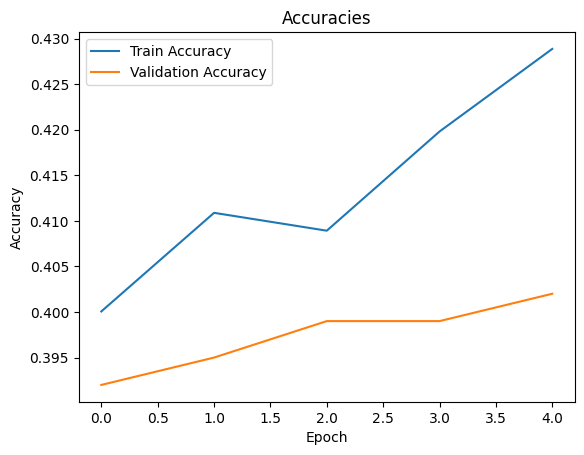

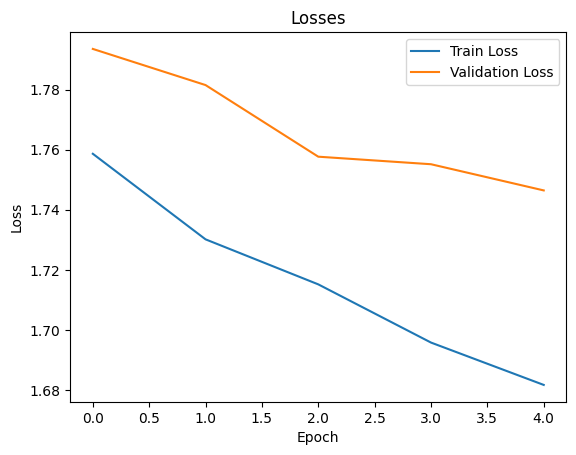

In [ ]:
# TODO: Check the accuracy of the model
# This generic function will be used to check the model performance on both the training and validation datasets using the given loader, after each epoch
# So that, you can use the same function to check the model performance on both the training and validation datasets with different loaders
# The function should return the accuracy and the total loss
# The accuracy is calculated by dividing the number of correct predictions by the total number of predictions

def check_accuracy_and_loss(loader, model): 
    acc = 0
    total_loss = 0
    # === Your Code Here (5 pts) ===
    num_correct = 0
    num_samples = 0
    num_batches = len(loader)
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Get to correct shape
            #x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)
            total_loss += loss_fn(scores, y).item()

            num_correct += (predictions == y).sum()

            num_samples += predictions.size(0)

    model.train()
    acc = num_correct / num_samples
    total_loss /= num_batches
    # === === ===
    return acc, total_loss


# TODO: Train the model with SGD 
# Check train loss and train accuracy after each epoch, and validate accuracy after each epoch
# Store them, and plot them at the end
# Moreover, store losses and plot them at the end
# You should be able to get a train accuracy of around 40-45% and a validation accuracy of around 35-40%

torch.manual_seed(0)
np.random.seed(0)

model = SingleLayerNN(input_size=3072, output_size=10)
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # === Your Code Here (10 pts) ===

    #size = len(loader_train.dataset)
    model.train()
    for batch, (X, y) in enumerate(loader_train):
        # Compute prediction and loss
        pred = model(X)
        loss = criterion(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    acc, loss = check_accuracy_and_loss(loader=loader_train, model=model)
    train_accs.append(acc)
    train_losses.append(loss)
    acc, loss = check_accuracy_and_loss(loader=loader_val, model=model)
    val_accs.append(acc)
    val_losses.append(loss)
    # === === ===


plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

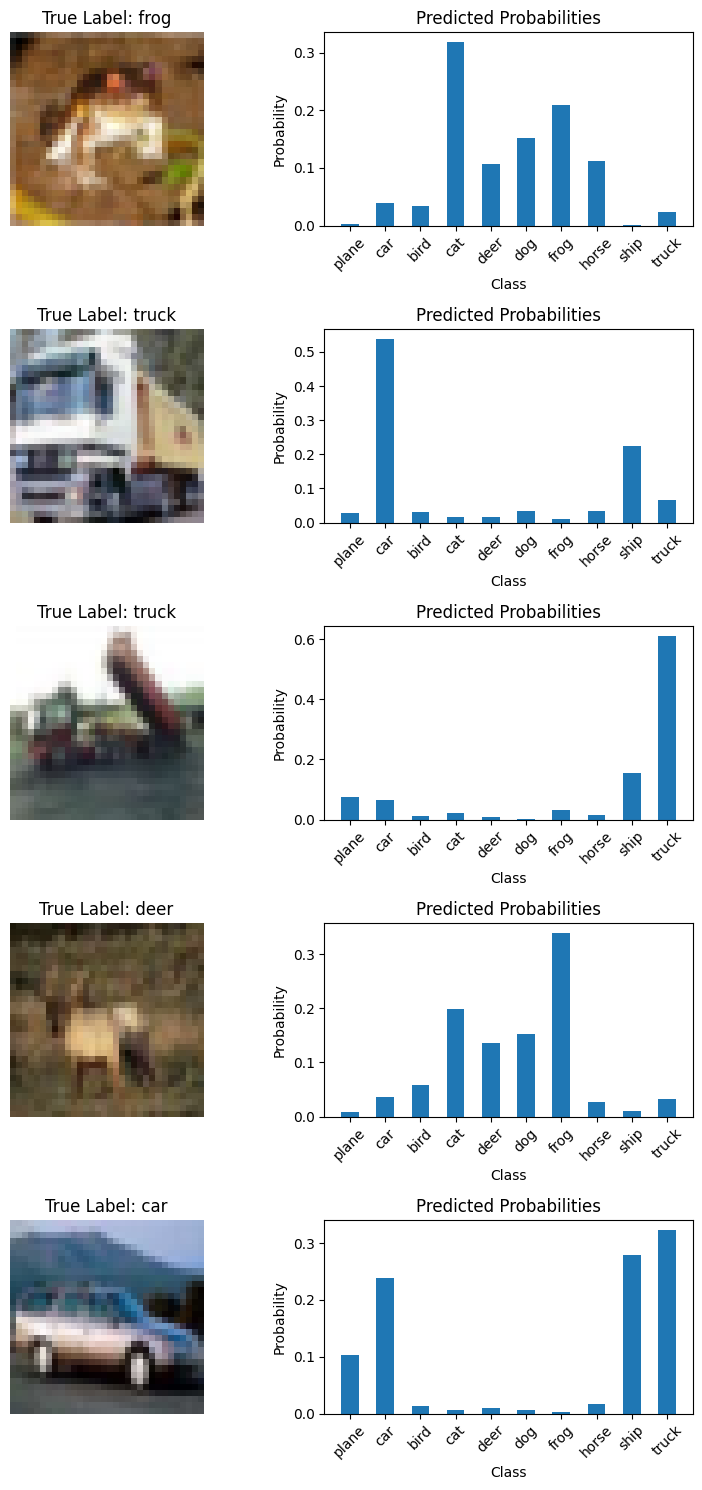

In [ ]:
# TODO: Plot proababilities for the first 5 image in the validation set, alongisde the image and the true label 
# You may find torch.nn.functional.softmax useful

# === Your Code Here (5 pts) ===
model.eval()

def denormalize_image(image, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    
    image = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return image

fig, axes = plt.subplots(5, 2, figsize=(8,15))

for i in range(5):
    image, label = cifar10_val[i]
    image = image.unsqueeze(0)  # Add batch dimension (1, 3, 32, 32)
    
    with torch.no_grad():
        scores = model(image)
        probabilities = torch.nn.functional.softmax(scores, dim=1).squeeze().cpu().numpy()
    
    # Denormalize image
    denormalized_image = denormalize_image(image.squeeze(), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    denormalized_image = denormalized_image.permute(1, 2, 0).numpy()  # Convert
    
    # Plot image
    axes[i, 0].imshow(denormalized_image)
    axes[i, 0].set_title(f"True Label: {classes[label]}")
    axes[i, 0].axis('off')

    # Plot probabilities
    axes[i, 1].bar(np.arange(10), probabilities, width=0.5, align='center')
    axes[i, 1].set_title('Predicted Probabilities')
    axes[i, 1].set_xlabel('Class')
    axes[i, 1].set_ylabel('Probability')
    axes[i, 1].set_xticks(np.arange(10))
    axes[i, 1].set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()

# === === ===


In [10]:
model.fc.weight.data.shape

torch.Size([10, 3072])

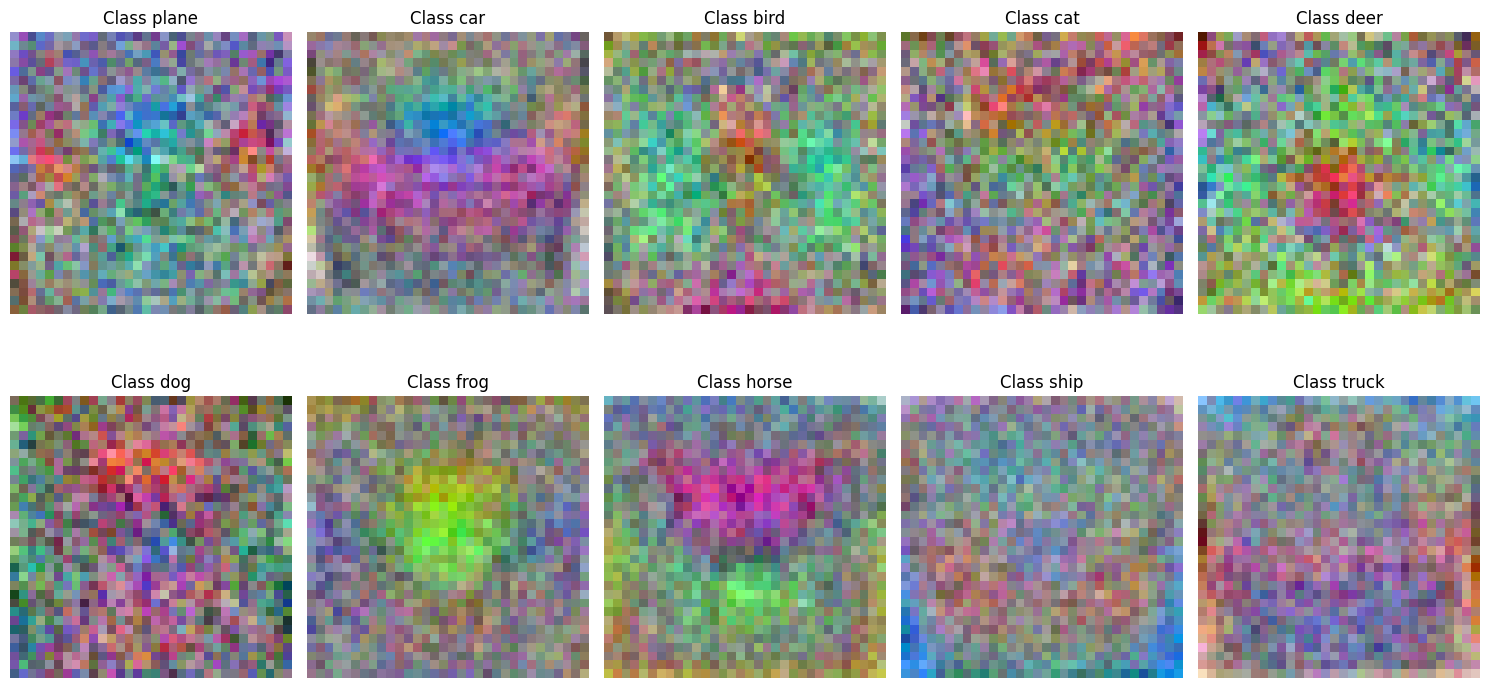

In [ ]:
# TODO: Visualize the learned weights for the model 
# You need to reshape the weights to the shape of the images and normalize them
# You can reach the model weights using model.fc.weight.data

# === Your Code Here (10 pts) ===
# Extract the weights
weights = model.fc.weight.data

# Normalize
weights_min = weights.min(dim=1, keepdim=True)[0]
weights_max = weights.max(dim=1, keepdim=True)[0]
normalized_weights = (weights - weights_min) / (weights_max - weights_min)

num_classes = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 8)) 

for i in range(num_classes):
    weight_img = normalized_weights[i].reshape(3, 32, 32).numpy()

    # Plot
    ax = axes[i // 5, i % 5]  
    ax.imshow(np.transpose(weight_img, (1, 2, 0)))  # Convert
    ax.set_title(f'Class {classes[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# === === ===

## QA (6 pts)
Q: How did you reshape the weights? Why did you reshape them that way? (2 pts)

A: Since the weights are flattened, they need to be reshaped to 32x32x3. I did this with .reshape(3, 32, 32), as this created 3 matrices of size 32x32 and fills the spots going one-by-one. Using .reshape(32, 32, 3) would create 32 matrices of size 32x3. 

---

Q: What each item in the weights tensor represents? What is the relationship between the weights and pixels in the image? (2 pts)

A: Each item in the weights tensor is related to how important that certain pixel's corresponding color value is. If a certain weight is large in the weights tensor, that means the model gives importance to how much red or green or blue that pixel is, depending on which color the weight corresponds. For each pixel in the image, there exist 3 weights for RGB and the pixel's RGB values are multiplied with the corresponding weights. Afterwards, the values coming from all of the pixels are summed and activation value is produced.

---

Q: What do you observe in the weights? What do you think they represent? Why? (2 pts)

A: There are certain patterns formed when we visualize the weights. These patterns are learned by the model and detected when a new data point is presented.

# Multiclass Classification using Binary Cross Entropy with Sigmoid (19 pts)

Epoch 1/5: Train Acc: 0.3509, Train Loss: 0.0006
Epoch 1/5: Val Acc: 0.3630, Val Loss: 0.4621
Epoch 2/5: Train Acc: 0.3738, Train Loss: 0.0006
Epoch 2/5: Val Acc: 0.3790, Val Loss: 0.4250
Epoch 3/5: Train Acc: 0.3776, Train Loss: 0.0005
Epoch 3/5: Val Acc: 0.3730, Val Loss: 0.4007
Epoch 4/5: Train Acc: 0.3906, Train Loss: 0.0005
Epoch 4/5: Val Acc: 0.4000, Val Loss: 0.3824
Epoch 5/5: Train Acc: 0.3965, Train Loss: 0.0005
Epoch 5/5: Val Acc: 0.4010, Val Loss: 0.3672


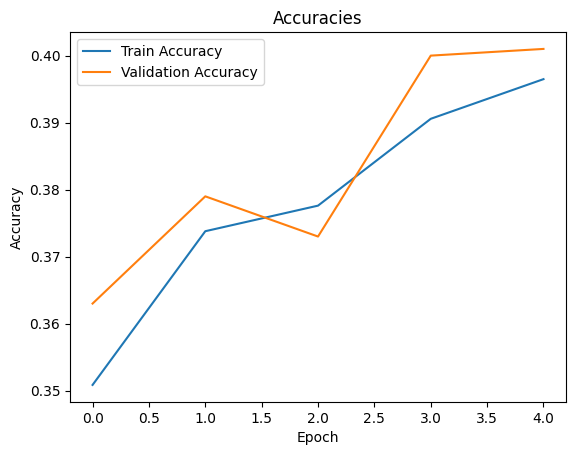

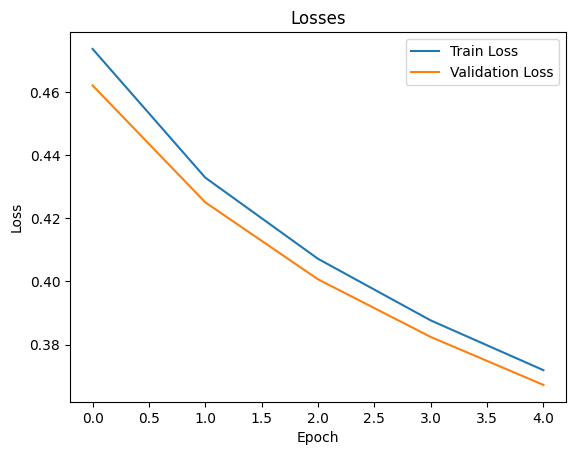

In [14]:
# TODO: Do the same as above, but now train using sigmoid and use one vs all loss 
# You should be able to get a train accuracy of around 45-50% and a validation accuracy of around 40-45%

class SingleLayerNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        # === Your Code Here (3 pts) ===
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
        # === === ===

def check_accuracy_and_loss(loader, model): 
    # === Your Code Here (2 pts) ===
    acc = 0
    total_loss = 0
    num_correct = 0
    num_samples = 0
    num_bathces = len(loader)
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            # Reshape input to match the model input size
            #x = x.view(x.size(0), -1)

            # Forward pass
            scores = model(x)

            # Calculate loss
            y_one_hot = torch.zeros_like(scores).scatter_(1, y.unsqueeze(1), 1)  # One-hot encode labels
            loss = criterion(scores, y_one_hot)
            total_loss += loss.item()

            # Calculate accuracy
            num_correct += (scores.argmax(dim=1) == y).sum()
            num_samples += y.size(0)

    acc = num_correct / num_samples
    total_loss /= num_bathces
    model.train()
    # === === ===

    return acc, total_loss

torch.manual_seed(0)
np.random.seed(0)

model = SingleLayerNN(3 * 32 * 32, 10)
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 5


train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # === Your Code Here (5 pts) ===
    model.train()
    train_loss = 0
    num_correct = 0
    num_samples = 0

    for x, y in loader_train:
        # Reshape input and one-hot encode labels
        #x = x.view(x.size(0), -1)
        y_one_hot = torch.zeros(x.size(0), 10).scatter_(1, y.unsqueeze(1), 1)

        # Forward pass
        scores = model(x)
        loss = criterion(scores, y_one_hot)
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    acc, loss = check_accuracy_and_loss(loader=loader_train, model=model)
    train_accs.append(acc)
    train_losses.append(loss)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Acc: {acc:.4f}, Train Loss: {loss / len(loader_train):.4f}")
    acc, loss = check_accuracy_and_loss(loader=loader_val, model=model)
    val_accs.append(acc)
    val_losses.append(loss)
    print(f"Epoch {epoch + 1}/{num_epochs}: Val Acc: {acc:.4f}, Val Loss: {loss:.4f}")

    # === === ===

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


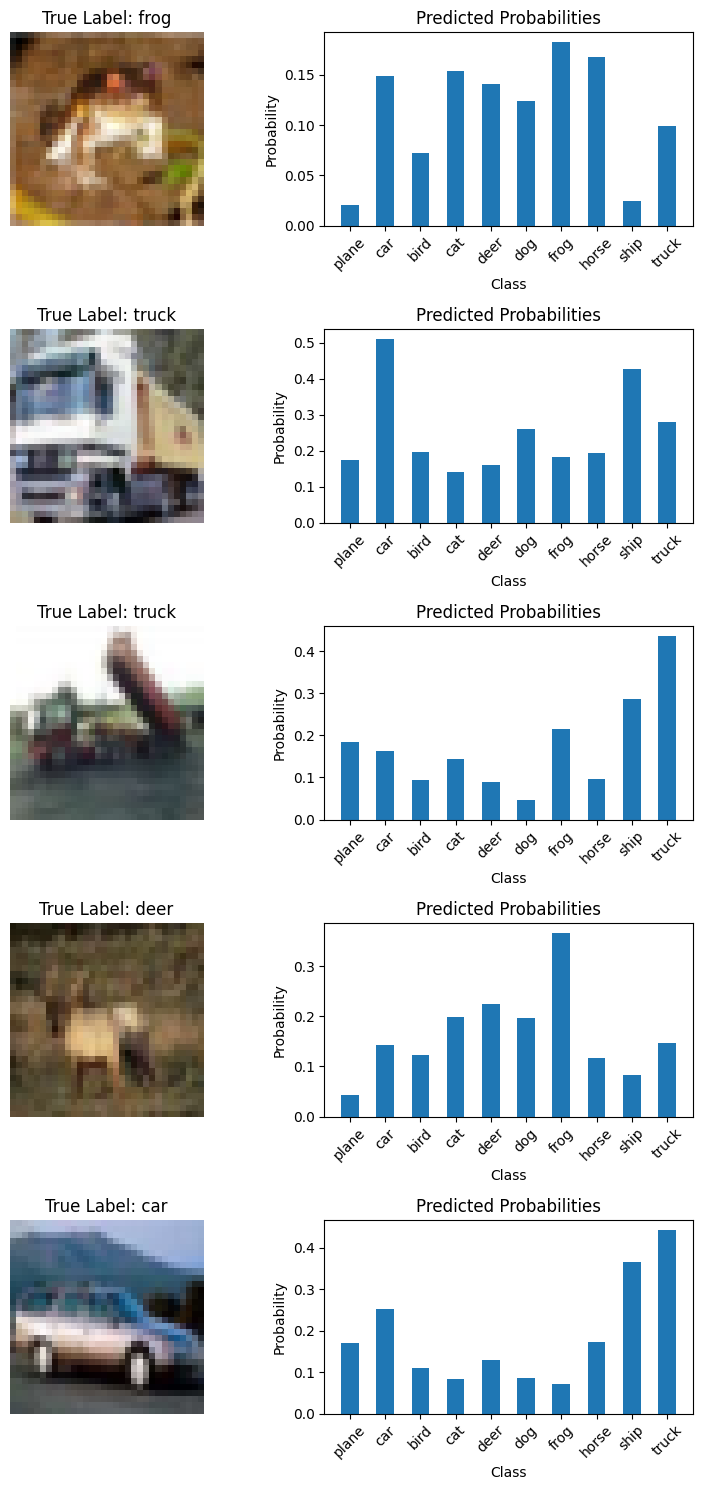

In [ ]:
# TODO: Plot proababilities for the first 5 image in the validation set, alongisde the image and the true label
# You may find torch.sigmoid useful

# === Your Code Here (3 pts) ===
model.eval()

def denormalize_image(image, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    image = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return image

fig, axes = plt.subplots(5, 2, figsize=(8,15))

for i in range(5):
    image, label = cifar10_val[i]
    image = image.unsqueeze(0)  # Add batch dimension (1, 3, 32, 32)
    
    with torch.no_grad():
        scores = model(image)
        probabilities = torch.sigmoid(scores).squeeze().numpy()
    
    # Denormalize image
    denormalized_image = denormalize_image(image.squeeze(), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    denormalized_image = denormalized_image.permute(1, 2, 0).numpy()  # Convert
    
    # Plot image
    axes[i, 0].imshow(denormalized_image)
    axes[i, 0].set_title(f"True Label: {classes[label]}")
    axes[i, 0].axis('off')

    # Plot probabilities
    axes[i, 1].bar(np.arange(10), probabilities, width=0.5, align='center')
    axes[i, 1].set_title('Predicted Probabilities')
    axes[i, 1].set_xlabel('Class')
    axes[i, 1].set_ylabel('Probability')
    axes[i, 1].set_xticks(np.arange(10))
    axes[i, 1].set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()
# === === ===

# QA (6 pts)

Q: What are the differences between the two models? What is the advantage of using one over the other? When would you need one over another? Give an example. (4 pts)

A: The first model uses softmax and cross entropy loss, and outputs probabilities that sum up to 1. The second model uses sigmoid and binary cross entropy, which means that for every class, there is a decision boundary. It is checked whether the image belongs to a given class or not, and the sum of probabilities may not sum up to 1. The first one is more useful for when we know each image belongs to exactly one class. The one-vs-all approach is useful when there is multiple classes which the image can belong to. For example if there is both a car and a pedestrian in the same image.

--- 

Q: How class imbalance can affect the training of the second model? (2 pts)

A: The model will be biased toward more frequent classes. If in the dataset there exist too few examples of a given class, its decision boundary will be pushed in a way that model will be biased toward thinking images are not of that class, giving false negatives.


## Multilayer Networks (19 pts)

Epoch 1/5: Train Acc: 0.2406, Train Loss: 0.0027
Epoch 1/5: Val Acc: 0.2500, Val Loss: 2.0477
Epoch 2/5: Train Acc: 0.3309, Train Loss: 0.0024
Epoch 2/5: Val Acc: 0.3450, Val Loss: 1.8679
Epoch 3/5: Train Acc: 0.3722, Train Loss: 0.0023
Epoch 3/5: Val Acc: 0.3840, Val Loss: 1.7559
Epoch 4/5: Train Acc: 0.4009, Train Loss: 0.0022
Epoch 4/5: Val Acc: 0.3970, Val Loss: 1.6926
Epoch 5/5: Train Acc: 0.4270, Train Loss: 0.0021
Epoch 5/5: Val Acc: 0.4240, Val Loss: 1.6092


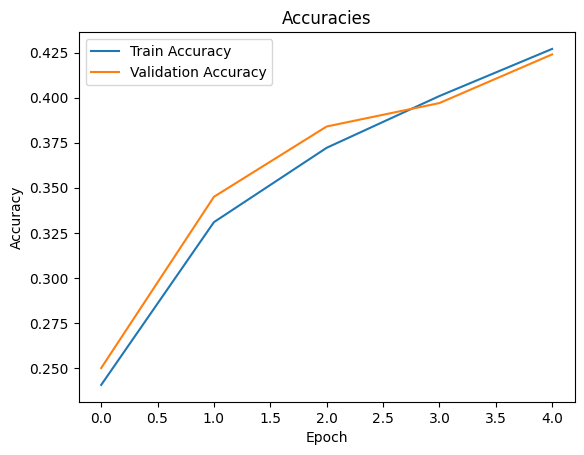

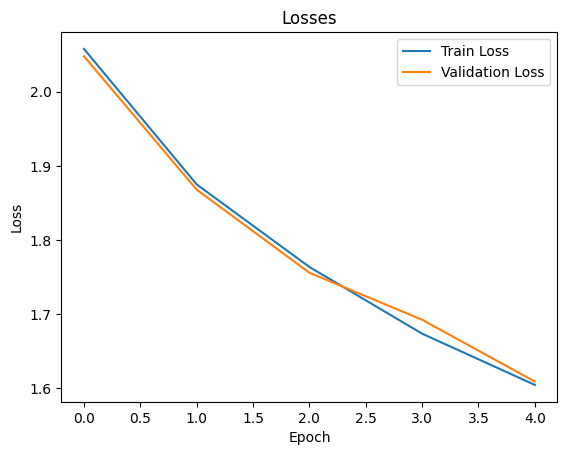

In [ ]:
# TODO: Now do the same with multi-layer neural network (20 pts)
# Relu is used as activation function between layers. Hidden layer size is 64.
# hidden_layer_num should be input as a parameter to the class
# You may find nn.ModuleList useful
# hidden_layer_num = K -> input_layer -> K hidden layers -> output_layer
# You may use the same training loop as above
# You should be able to get a train and validation accuracy of around 45-50%

class MultiLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layer_num=2):
        super().__init__()
        # === Your Code Here (3 pts) ===
        self.in_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_layer_num):
            hid_layer = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(hid_layer)
        self.out_layer = nn.Linear(hidden_size, output_size)

        # === === ===

    def forward(self, x):
        # === Your Code Here (3 pts) ===
        x = x.reshape(x.shape[0], -1)
        x = nn.functional.relu(self.in_layer(x))
        for i, hid_layer in enumerate(self.hidden_layers):
            x = nn.functional.relu(hid_layer(x))
        x = self.out_layer(x)
        return x
        # === === ===

def check_accuracy_and_loss(loader, model):
    # === Your Code Here (1 pts) ===
    acc = 0
    total_loss = 0
    num_correct = 0
    num_samples = 0
    num_batches = len(loader)
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Get to correct shape
            #x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)
            total_loss += loss_fn(scores, y).item()

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    acc = num_correct / num_samples
    total_loss /= num_batches
    # === === ===

    return acc, total_loss

torch.manual_seed(0)
np.random.seed(0)


model = MultiLayerNN(3 * 32 * 32, 64, 10, 2)
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # === Your Code Here (1 pts) ===
    model.train()
    for batch, (X, y) in enumerate(loader_train):
        # Compute prediction and loss
        pred = model(X)
        loss = criterion(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    acc, loss = check_accuracy_and_loss(loader=loader_train, model=model)
    train_accs.append(acc)
    train_losses.append(loss)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Acc: {acc:.4f}, Train Loss: {loss / len(loader_train):.4f}")
    acc, loss = check_accuracy_and_loss(loader=loader_val, model=model)
    val_accs.append(acc)
    val_losses.append(loss)
    print(f"Epoch {epoch + 1}/{num_epochs}: Val Acc: {acc:.4f}, Val Loss: {loss:.4f}")
    # === === ===


plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Training model with 1 hidden layer(s)...

Training model with 2 hidden layer(s)...

Training model with 3 hidden layer(s)...


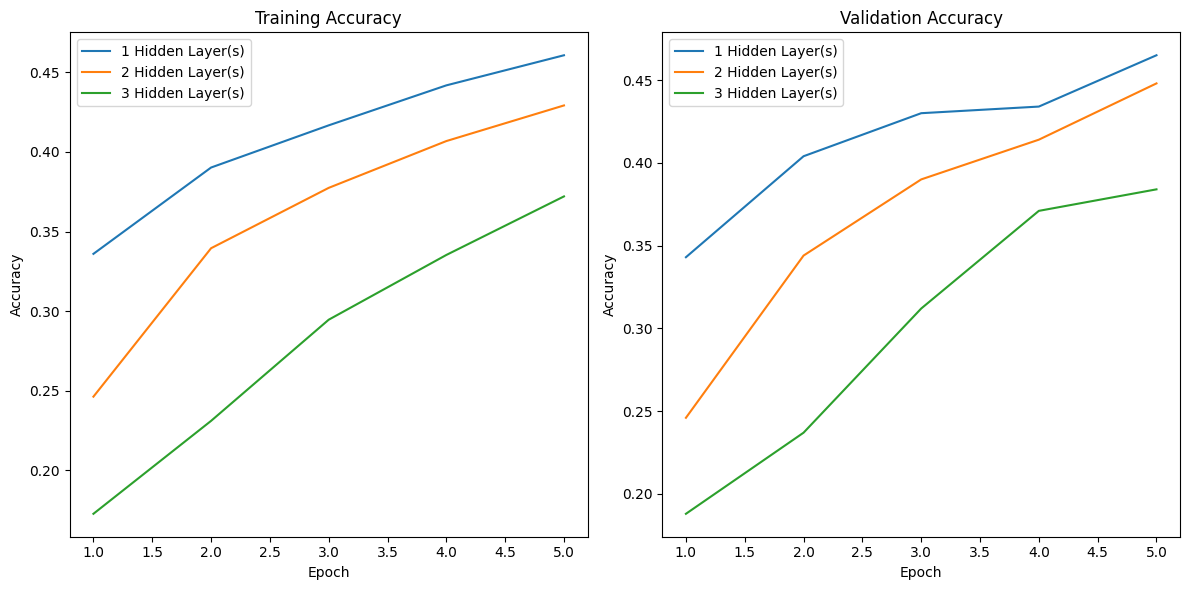

In [19]:
# TODO: Change the number of hidden layers to values between 1, 2, and 3, train them for 5 epochs
# Store the train and validation accuracies with respect to the number of hidden layers

# Check the accuracy of the model
def check_accuracy_and_loss(loader, model): 
    # === Your Code Here (1 pts) ===
    acc = 0
    total_loss = 0
    num_correct = 0
    num_samples = 0
    num_batches = len(loader)
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Get to correct shape
            #x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)
            total_loss += loss_fn(scores, y).item()

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    acc = num_correct / num_samples
    total_loss /= num_batches
    # === === ===

    return acc, total_loss


# TODO: Train them. Plot all training and validation accuracies, epoch vs accuracy, different lines for different number of hidden layers

# === Your Code Here (6 pts) ===
hidden_layers = [1, 2, 3]
train_accuracies = {}
val_accuracies = {}


for num_layers in hidden_layers:
    print(f"\nTraining model with {num_layers} hidden layer(s)...")
    
    # Initialize model, optimizer, and loss function
    model = MultiLayerNN(3 * 32 * 32, 64, 10, hidden_layer_num=num_layers)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        for batch, (X, y) in enumerate(loader_train):
            
            pred = model(X)
            loss = criterion(pred, y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        
        acc, _ = check_accuracy_and_loss(loader=loader_train, model=model)
        train_accs.append(acc)
        acc, _ = check_accuracy_and_loss(loader=loader_val, model=model)
        val_accs.append(acc)
    
    
    train_accuracies[num_layers] = train_accs
    val_accuracies[num_layers] = val_accs

# Plot training and validation accuracies
plt.figure(figsize=(12, 6))

# Plot training accuracies
plt.subplot(1, 2, 1)
for num_layers, accs in train_accuracies.items():
    plt.plot(range(1, num_epochs + 1), accs, label=f"{num_layers} Hidden Layer(s)")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot validation accuracies
plt.subplot(1, 2, 2)
for num_layers, accs in val_accuracies.items():
    plt.plot(range(1, num_epochs + 1), accs, label=f"{num_layers} Hidden Layer(s)")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# === === ===


# QA (4 pts)
Q: What is the effect of increasing the number of hidden layers on the training and validation accuracies? Why? (2 pts)

A: 

---

Q: When you should prefer using a single layer neural network over a multi-layer neural network? (2 pts)

A:


# Open Ended Questions (5 pts)


Q: Given a fixed random permutation for image pixels, and a trained liner classifier W in shape (32 * 32 * 3, 10) performing well (eg 99% accuracy) on normal images;
how would you find the permutation of pixels by just using permuted images, class labels, and the original weight matrix W. Give a detailed explanation. (3 pts)

Toy example with 9 pixels:

* Original image order, I:

  A B C

  D E F

  G H I

* Trained weight matrix W, on normal images of order [A, B, C, D, E, F, G, H, I]

* Permutation function f, such that f(I) = I_p

* I_p:

  H F G

  D B E
  
  I C A

How would you find f using W and I_permuted?


A: We can try random permutations of I_permuted and classify these using W to test whether we obtained the original image, because W is 99% accurate. But this would take long and also the fact that W classifies an image correctly does not guarantee that it is the original image.<br>
Another approach would be examining the activations of the 10 neurons of W, which is equal to the class scores. We can observe the activations of specific regions of W. If a pixel or group of pixels are at the correct place, their multiplication with the corresponding weights with the correct class row in W should yield a high value.<br>
Trying different permutations of W itself, we can figure out the permutation function f. 

---

Q: How can you maximize performance of the model in the training process? Are there any disadvantages of focusing only on the training accuracy, or training loss? (2 pts)

A: Focusing only on the training accuracy would lead to oevrfitting. Higher training accuracy is not the goal, as the model will have to deal with unseen data after training. To maximize training accuracy, we can increase the number of epochs. But to increase generalization and the overall training process: Regularization and data augmentation can be employed to generalize, and learning rate scheduling can be used for faster convergence.